In [15]:
import numpy as np

# TODO Remove all that have more than 1 class and train in a single-labeled way instead
# Do filtering here, and copy notebook instead.


def split_test_train(data, train_perc, key):
    train_num = int(len(data)*train_perc)

    return (
        (
            np.array([t[key] for t in data[:train_num]]),
            np.array([t["genres"] for t in data[:train_num]])
        ),
        (
            np.array([t[key] for t in data[train_num:]]),
            np.array([t["genres"] for t in data[train_num:]])
        )
    )


def split_x_y(data, key):
    return (
        np.array([t[key] for t in data]),
        np.array([t["genres"] for t in data])
    )

In [35]:
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


tf.keras.backend.clear_session()
tf.get_logger().setLevel("ERROR")


def get_model(input_dim, hidden_dim, output_dim, lr=0.01):
    if hidden_dim:
        model = Sequential([
            Dense(hidden_dim[0], input_dim=input_dim, activation='relu')
        ])

        for h in hidden_dim[1:]:
            model.add(Dense(h, activation="relu"))
        model.add(Dense(output_dim, activation='sigmoid'))
    else:
        model = Sequential([
            Dense(output_dim, input_dim=input_dim, activation='sigmoid')
        ])
    
    hamming_loss = tfa.metrics.HammingLoss(mode="multilabel", threshold=.5)
    f1_score = tfa.metrics.F1Score(output_dim, average="weighted")
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[hamming_loss, f1_score])
    return model

In [33]:
from sklearn.metrics import hamming_loss as sk_hamming_loss, f1_score as sk_f1_score
from sklearn.model_selection import RepeatedKFold


def hamming_loss(y_pred, y_true):
    return sk_hamming_loss(y_true, y_pred)


def f1_score(y_pred, y_true):
    return sk_f1_score(y_true, y_pred, average="weighted")


def evaluate(x, y, threshold=.5):
    hamming_losses = []
    f1_scores = []
    input_dim, output_dim = x.shape[1], y.shape[1]

    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    for i, (train_i, test_i) in enumerate(cv.split(x)):
        x_train, x_test = x[train_i], x[test_i]
        y_train, y_test = y[train_i], y[test_i]

        model = get_model(input_dim=input_dim, hidden_dim=[100, 40], output_dim=output_dim, lr=0.001)
        history = model.fit(x_train, y_train, verbose=0, epochs=200)
    
        y_pred = model.predict(x_test)
        binary_pred = [[round(y_val-threshold+.5) for y_val in pred] for pred in y_pred]

        hamming_losses.append(hamming_loss(binary_pred, y_test))
        f1_scores.append(f1_score(binary_pred, y_test))

        print("%s: %.3f" % (i+1, f1_scores[-1]))

        # acc = rounding_acc(model, x_test, y_test)
        # results.append(acc)

        # print("%s: %.3f" % (i, mean(results)))
    return hamming_losses, f1_scores

In [17]:
import json

run_types = [
    {
        "src_file": "nrc/nrc_vect.json",
        "key": "emotions"
    },
    {
        "src_file": "nvidia/nvid_vect.json",
        "key": "emotions"
    },
    {
        "src_file": "distilbert/dist_vect.json",
        "key": "embeddings"
    },
    {
        "src_file": "distilbert/ob_vect.json",
        "key": "emotions_embeddings"
    }
]

run_choice = run_types[2]

with open(run_choice["src_file"]) as file:
    data = json.load(file)

x, y = split_x_y(data["movies"], run_choice["key"])
labels = data["genre_order"]

In [34]:
hamming_losses, f1_scores = evaluate(x, y)

print("Avg. hamming loss: %.3f (std.dev: %.3f)" % (np.mean(hamming_losses), np.std(hamming_losses)))
print("Avg. f1-score: %.3f (std.dev: %.3f)" % (np.mean(f1_scores), np.std(f1_scores)))

1: 0.607
2: 0.614
3: 0.620
4: 0.541
5: 0.612
6: 0.630
7: 0.621
8: 0.622


KeyboardInterrupt: 

In [39]:
input_dim, output_dim = x.shape[1], y.shape[1]

(x_train, y_train), (x_test, y_test) = split_test_train(data["movies"], .9, run_choice["key"])

model = get_model(input_dim=input_dim, hidden_dim=[20], output_dim=output_dim, lr=0.001)
history = model.fit(x_train, y_train, verbose=0, epochs=300)

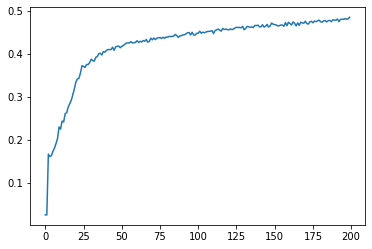

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history["f1_score"])

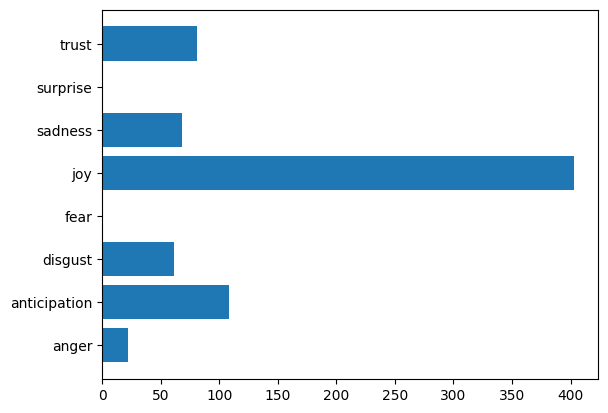

In [58]:
emotions = np.array([np.array(m["emotions"]) for m in data["movies"]])
summed = emotions.sum(axis=0)

plt.rcdefaults()
fig, ax = plt.subplots()

emotions = data["emotion_order"]
y_pos = np.arange(len(emotions))

ax.barh(y_pos, width=summed)
ax.set_yticks(y_pos)
ax.set_yticklabels(emotions)

plt.show()